In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F
from torch.nn.functional import relu
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import numpy as np
import gc
from pylab import *
import os
import random
import json
import pandas as pd
from scipy.stats import norm
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import sys
import matplotlib.pyplot as plt
import time

from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

np.set_printoptions(precision = 4, suppress = True)
torch.set_printoptions(precision=2)
device = torch.device("cuda")
torch.cuda.set_device(0)

In [2]:
# Set Hyperparameters

# Fixed
n_head = 1
d = 5
B = 1000
ma = 1
var = 0.05
shape_k = 0.1

# Number of Iterations to run
max_iters = 10000
hist_stride = 1 # stride for saved model paramters in `train.ipynb'
stride = 50 # stride for computing loss

# We vary the following parameters
n_layer = 3
mode = 'normal'
N = 20
seeds = [0,1,2,3,4,5]


In [3]:
log_dir = 'log'
loss_plots = {}

for sd in seeds:
    for (alg, toclip, lr) in [('sgd', True, 0.02),('adam', True, 0.02)]:  
        filename = log_dir + '/train_layer{}_N{}_{}_{}_{}_lr{}_sd{}.pth'.format(n_layer, N, mode, alg, toclip, lr, sd)
        loaded_dict = torch.load(filename)
        hist_list = loaded_dict['hist_list']

        np.random.seed(99)
        torch.manual_seed(99)
        Z, y = generate_data(mode,N,d,B,shape_k)
        Z = Z.to(device)
        y = y.to(device)

        model = Transformer_F(n_layer, n_head, d, var)
        model = model.to(device)
        
        test_losses = torch.zeros(max_iters//stride)

        for t in range(0,max_iters,stride):
            allparam_loaded = hist_list[t]
            with torch.no_grad():
                model.allparam.copy_(allparam_loaded)
            test_loss = in_context_loss(model, Z, y)
            test_losses[t//stride] = test_loss.item()

        loss_plots[(alg, toclip, lr, sd)] = test_losses

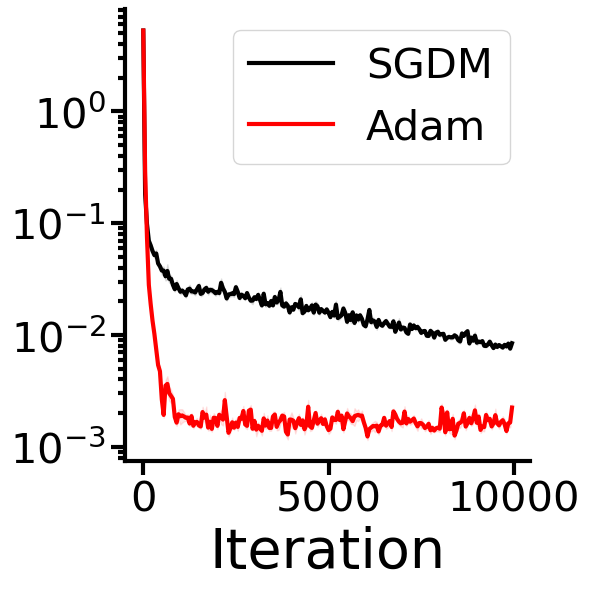

In [4]:
fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (6, 6))

for (alg, toclip, lr) in [('sgd', True, 0.02),('adam', True, 0.02)]:
    losses = torch.zeros(len(seeds), int(max_iters/stride))
    for idx, sd in enumerate(seeds):
        losses[idx] = loss_plots[(alg, toclip, lr, sd)]
    losses_mean = torch.mean(losses, axis=0)
    losses_std = torch.std(losses, axis=0)
    if alg == 'sgd':
        ax.plot(range(0,max_iters,stride), losses_mean, color = 'black', lw = 3,label='SGDM')
        ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std/4, losses_mean+losses_std/4, color = 'black', alpha = 0.1)
    elif alg == 'adam':
        ax.plot(range(0,max_iters,stride), losses_mean, color = 'red', lw = 3, label='Adam')
        ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std/4, losses_mean+losses_std/4, color = 'red', alpha = 0.1)

    ax.set_xlabel('Iteration',fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
    ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
    ax.legend(fontsize=30)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(fig_dir + '/loss_layer{}_N{}_{}.pdf'.format(n_layer, N, mode), dpi=600)